In [1]:
#Modelo DistilBETO Cleaned 2-epoch

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from transformers import DistilBertForSequenceClassification, AdamW, DistilBertTokenizer
from transformers import get_linear_schedule_with_warmup
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import STOPWORDS
import re,string
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from string import punctuation
from nltk.corpus import wordnet


MAX_LEN = 85

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df_train = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/80-10-10/train.csv')
print(df_train.shape)
df_train.isnull().sum()
df_train.sentiment.replace("P" , 2 , inplace = True)
df_train.sentiment.replace("N" , 0 , inplace = True)
df_train.sentiment.replace("NEU" , 1, inplace = True)
df_train.head()
df_train['review'] = df_train['text']
df_train.drop('text', axis=1, inplace=True)
df_train['label'] = df_train['sentiment']
df_train.drop('sentiment', axis=1, inplace=True)

df_dev = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/80-10-10/dev.csv')
print(df_dev.shape)
df_dev.isnull().sum()
df_dev.sentiment.replace("P" , 2 , inplace = True)
df_dev.sentiment.replace("N" , 0 , inplace = True)
df_dev.sentiment.replace("NEU" , 1, inplace = True)
df_dev['review'] = df_dev['text']
df_dev.drop('text', axis=1, inplace=True)
df_dev['label'] = df_dev['sentiment']
df_dev.drop('sentiment', axis=1, inplace=True)

df_test = pd.read_csv('/Users/nfanlo/dev/spanish-classifier-tfg/dataset/80-10-10/test.csv')
print(df_dev.shape)
df_test.isnull().sum()
df_test.sentiment.replace("P" , 2 , inplace = True)
df_test.sentiment.replace("N" , 0 , inplace = True)
df_test.sentiment.replace("NEU" , 1, inplace = True)
df_test['review'] = df_test['text']
df_test.drop('text', axis=1, inplace=True)
df_test['label'] = df_test['sentiment']
df_test.drop('sentiment', axis=1, inplace=True)


(5787, 2)
(723, 2)
(723, 2)


In [2]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS


#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [3]:
review_new_train = []
review_new_dev = []
review_new_test = []

for t in df_train.review:
    review_new_train.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

for t in df_dev.review:
    review_new_dev.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

for t in df_test.review:
    review_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [4]:
df_train['review'] = review_new_train
df_dev['review'] = review_new_dev
df_test['review'] = review_new_test

X_train = df_train.iloc[:, 0]
y_train = df_train.iloc[:, 1]
X_dev = df_dev.iloc[:, 0]
y_dev = df_dev.iloc[:, 1]
X_test = df_dev.iloc[:, 0]
y_test = df_dev.iloc[:, 1]

In [13]:
# Tokenization

tokenizer = DistilBertTokenizer.from_pretrained('/Volumes/NFANLO/TFG/DistilBeto-Cleanned-Final/80-10-10/Final-model/tokenizer',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_test_inputs, X_test_masks = preprocessing(X_test)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_test_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/dev/spanish-classifier-tfg/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 41


In [14]:
#Data loaders
batch_size = 32

y_test_labels = torch.tensor(y_test.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

test_dataloader = dataloader(X_test_inputs, X_test_masks, y_test_labels)

In [15]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = DistilBertForSequenceClassification.from_pretrained('/Volumes/NFANLO/TFG/DistilBeto-Cleanned-Final/80-10-10/Final-model/model', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 5e-5)

epochs=1

total_steps = len(test_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

/Users/nfanlo/dev/spanish-classifier-tfg/.venv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.2, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.2, inplace=False)
       

In [17]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

======= Epoch 1 / 1 =======


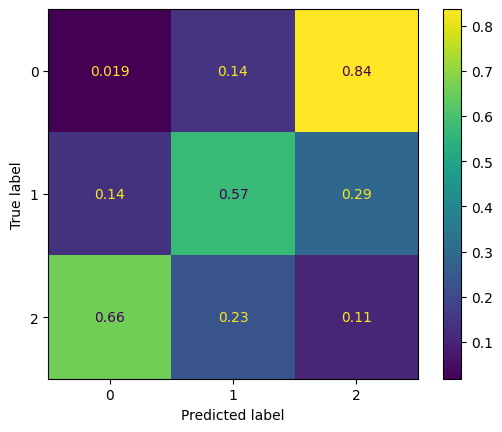

              precision    recall  f1-score   support

           1       0.03      0.02      0.02       269
           2       0.60      0.57      0.59       239
           3       0.07      0.11      0.09       215

    accuracy                           0.23       723
   macro avg       0.23      0.23      0.23       723
weighted avg       0.23      0.23      0.23       723

f1 score macro: 0.23159418381208327
accuracy score: 0.2268326417704011
precision score: 0.23484975541579314
recall score: 0.2315339205615359


In [18]:
#Definimos la funcion para pasar el test por el modelo y entregar los resultados
all_logits_test = []
all_labels_test = []
avg_train_loss_test = []

def training(n_epochs, test_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0

        # Evalua el data para un epoch mas
        for step, batch in enumerate(test_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits_test.extend(predict_labels.tolist())
            all_labels_test.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy
    
    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels_test, all_logits_test, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()
  
    target_names = ['1', '2', '3']
    print(classification_report(all_labels_test, all_logits_test, target_names=target_names))
    
    print("f1 score macro:", f1_score(all_labels_test, all_logits_test, average='macro'))
    print("accuracy score:", accuracy_score(all_labels_test, all_logits_test))
    print("precision score:", precision_score(all_labels_test, all_logits_test, average='macro'))
    print("recall score:", recall_score(all_labels_test, all_logits_test, average='macro'))




#Llamamos a la funcion para entrenar el modelo
training(epochs, test_dataloader)        